In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import xgboost as xgb
from sklearn.metrics import f1_score, classification_report


from sklearn.model_selection import StratifiedKFold, cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

import scikitplot as skplt
import catboost as ctb
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_hdf("../input/train_taiwan.h5")
df_test = pd.read_hdf("../input/test_taiwan.h5")

df_all = pd.concat([df_train, df_test]).reset_index(drop=True)
df_all.columns = [x.replace(" ", "_").lower() for x in df_all.columns]

df_train.shape, df_test.shape, df_all.shape

((3409, 97), (3410, 96), (6819, 97))

In [4]:
def make_experiment(model, feats=None, threshold=0.5, n_splits=3, black_list=["target",'id']):

    if feats is None:
        num_feats = df_all.select_dtypes("number").columns
        feats = [x for x in num_feats if x not in black_list]

    df_train = df_all[ df_all["target"].notnull() ]
    X_train = df_train[feats].values
    y_train = df_train["target"].values

    scores = []
    cv=StratifiedKFold(n_splits=n_splits)#shuffle=True, random_state=0
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        #y_pred = model.predict(X_train[test_idx])

        print(classification_report(y_train[test_idx], y_pred))
        skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred, normalize=True)
        skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = f1_score(y_train[test_idx], y_pred)
        scores.append(score)

    
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring="f1", random_state=0)

In [5]:
df_all['cash_my'] = df_all.apply(lambda x: 1 if x['cash_/_total_assets'] <=0.05 else 0, axis =1) 

In [6]:
df_all['cash_turnover_rate_my'] = df_all.apply(lambda x: 1 if x['cash_turnover_rate'] <=0.0001 else 0, axis =1) 

In [7]:
def reset_outlires(df_all, feat, prc=1, prc2=99):
    cut_value1 = np.percentile(df_all[feat], prc)
    cut_value2 = np.percentile(df_all[feat], prc2)
    
    df_all[feat] = df_all[feat].map(lambda x: x if x != 1 and  x != 0 else -1)

In [8]:
reset_outlires(df_all, 'borrowing_dependency')

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1100
         1.0       0.48      0.62      0.54        37

    accuracy                           0.97      1137
   macro avg       0.73      0.80      0.76      1137
weighted avg       0.97      0.97      0.97      1137

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1100
         1.0       0.38      0.58      0.46        36

    accuracy                           0.96      1136
   macro avg       0.68      0.78      0.72      1136
weighted avg       0.97      0.96      0.96      1136

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      1099
         1.0       0.41      0.73      0.52        37

    accuracy                           0.96      1136
   macro avg       0.70      0.85      0.75      1136
weighted avg       0.97      0.96      0.96      1136

Score:  0.508995592

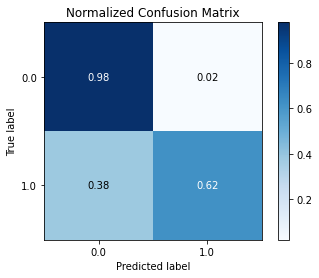

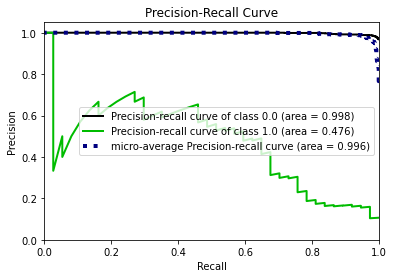

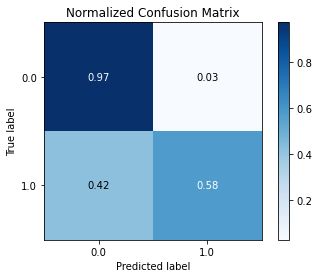

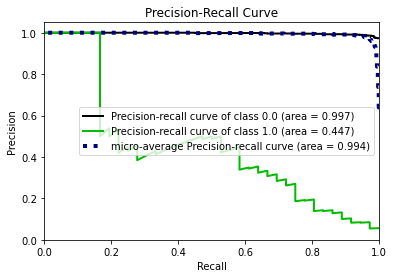

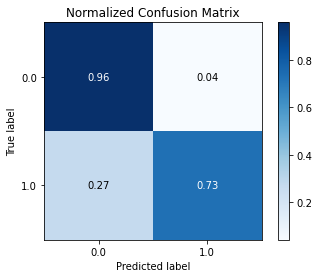

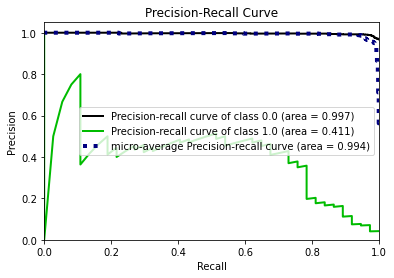

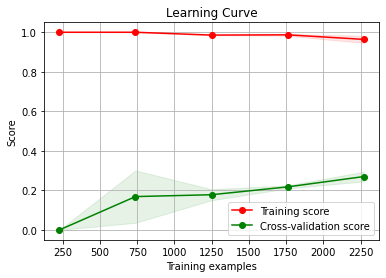

In [9]:
model = ctb.CatBoostClassifier(n_estimators=240, depth=5, random_state=0, verbose=False)
make_experiment(model, threshold=0.1)